In [76]:
import datetime as dt
import pandas as pd # pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import casadi as ca

plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('figure',figsize=(10,8))


def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')

    return ax1

In [30]:
# importing the data and getting the all the meters with full data
# consumptionLoad = pd.read_csv("D:\Onedrive\Leuven\Final project\data\consumption.csv",index_col = "meter_id")

In [31]:
# consumptionLoad = consumptionLoad.transpose()
# consumptionLoad.info()

In [32]:
# consumptionLoad.index = pd.to_datetime(consumptionLoad.index)
# consumptionLoad.info()

In [33]:
# # Getting the time-series with full year data
# data_monthly = consumptionLoad.resample('MS',axis=0).sum()
# new_index_months = data_monthly.index.month_name()
# data_monthly.set_index(new_index_months,inplace=True)
# ### Create an empty dataframe to store the first index of non zero value
# first_non_zero_ind = pd.DataFrame(index = ['first_non_zero_row'])
#
# ### Create empty list to store IDs of TS to remove (because they are full of zeros/NaN only)
# ID_NaN = []
# ### Loop through the columns and though the indexes of the dataframe
# for col_ind in range(len(data_monthly.columns)):
#     ID = data_monthly.columns[col_ind]
#     for row_ind in range(len(data_monthly.index)):
# ### we check for non zero values, but only if a first value has not been selected yet
#         if (data_monthly.iloc[[row_ind],[col_ind]].values != 0) and (not ID in first_non_zero_ind.columns):
#             first_non_zero_ind.insert(col_ind,ID,[row_ind]) #The value inserted indicates when the data starts
# ### in the case of an 'empty' TS, we place a NaN and we save the ID of this TS
#         elif ( all(val == 0 for val in data_monthly[[ID]].values) ) and (not ID in first_non_zero_ind.columns):
#             first_non_zero_ind.insert(col_ind,ID,np.NaN)
#             ID_NaN.append(ID)
#
# print("Meter without data: {}.".format(ID_NaN))
#
# meters_with_full_data = first_non_zero_ind.columns[first_non_zero_ind.iloc[0] == 0]
# fullYeardata = consumptionLoad[meters_with_full_data]
#
# # Directly loading in order to save time.
# # fullYeardata.to_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv")
#

In [34]:
# fullYeardata = fullYeardata.fillna(value = 10**5)
# fullYeardata.isnull().sum(axis=0)

In [35]:
# # Dealing with missing values --> avoiding the introduction of the estimation error by dropping the missing days.

In [36]:
# # removing the time-series with zero daily consumption
# fydc_new_daily = fullYeardata.resample('D',axis=0).sum()
# amountZeroDays = dict()
#
# for col in fydc_new_daily.columns:
#     count = 0
#     for row in fydc_new_daily.index:
#         value = fydc_new_daily.loc[row,col]
#         if value == 0:
#             count = count + 1
#     amountZeroDays[col] = count
#

In [37]:
# originalLength = fullYeardata.shape[1]
# for key in amountZeroDays:
#     if amountZeroDays[key] > 0:
#         fullYeardata.drop(key,axis=1,inplace=True)
#         print("Meter that is dropped: %s."% key)
# newLength = fullYeardata.shape[1]
# print("Amount of meters original: %s.\nAfter removal: %s."%(originalLength,newLength))

In [57]:
# fullYeardata = fullYeardata.replace(to_replace=10**5,value=np.nan)
# fullYeardata.to_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv")

In [58]:
# Still containing nan values
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv",index_col= "date",parse_dates= True)

### Baseline model: same forecast as same day previous week
All the baseline models:
1. find most similar consumption in trainingset based on id house, which day, which time, which temperature ok
2. previous day ok
3. previous week ok
4. Mean forecast based on time of day and type of day
5. Empirical mape minimization

In [59]:
# drop all the nan values that are in the time-serie
name = fullYeardata.columns[0]
TS = fullYeardata[name]
TS_december = TS[TS.index.month == 12]

previous day and week

In [60]:
# The model will not always produce an output --> can be that the previous day is not known
def base_model_week_before(test_dates: pd.DatetimeIndex,serie: pd.Series,amount_days:int = 7):
    base_forecast = pd.Series(index= test_dates,name= 'base_forecast: ' + str(amount_days) + ' days')
    for d in test_dates:
        get_date = d + dt.timedelta(days=-amount_days)
        forecast = serie.loc[get_date]
        base_forecast[d] = forecast

    return base_forecast

In [61]:
forecast1 = base_model_week_before(TS_december.index,TS)
forecast2 = base_model_week_before(TS_december.index,TS,amount_days=1)
# ax1 = figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
# forecast1.plot(ax=ax1,grid=True,lw=3.0)
# forecast2.plot(ax=ax1,grid=True,lw=3.0)
# plt.show()

C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
test_TS = TS_december

In [63]:
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv",index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)
av_temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-01-01 to 2017-12-31
Columns: 3248 entries, 0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 to 0x7b5ab0d98465e18c8efc1969685e814293352a1b
dtypes: float64(3248)
memory usage: 9.0 MB


In [64]:
TS_av_temperature = av_temperature[name]

In [65]:
# importing the holidays
from pandas.tseries.holiday import (
    AbstractHolidayCalendar, DateOffset, EasterMonday,
    GoodFriday, Holiday, MO,
    next_monday, next_monday_or_tuesday)
class EnglandAndWalesHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=next_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May bank holiday',
                month=5, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('Spring bank holiday',
                month=5, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Summer bank holiday',
                month=8, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Christmas Day', month=12, day=25, observance=next_monday),
        Holiday('Boxing Day',
                month=12, day=26, observance=next_monday_or_tuesday)
    ]

find the corresponding weekday based on kind of day and temperature

In [66]:
# normalization is not really necessary
def norm(serie: pd.Series):
    values = serie.values
    l = len(values)
    values = values.reshape((l, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    norm_serie = scaler.transform(values)
    norm_serie = norm_serie.squeeze()
    norm_serie = pd.Series(data=norm_serie,index=serie.index)
    return norm_serie

def get_closest_day(training_days: pd.DatetimeIndex,temperature: pd.Series,daily_temp:float):
    day = abs(temperature[training_days] - daily_temp).idxmin()
    return day

def find_most_similar_day(test_dates: pd.DatetimeIndex,serie: pd.Series,temperature: pd.Series):
    # The assumption is made that the test_dates are one continuous sequence of days
    daily_test_dates = pd.date_range(start=test_dates[0],end=test_dates[-1],freq='D')
    base_forecast = pd.Series(index= test_dates,name= 'closest_day_forecast')
    temperature = norm(temperature)

    for day in daily_test_dates:
        training_days = pd.date_range(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1),freq='D')
        holidays = EnglandAndWalesHolidayCalendar().holidays(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1))
        training_days = training_days.symmetric_difference(holidays)
        day_temp = temperature[temperature.index.dayofyear == day.dayofyear][0]

        if day in holidays:
            # look for holiday and Sunday (to get more days) --> we know that similarity is highest with Sunday
            sundays = training_days[training_days.weekday == 6]
            training_days = sundays.union(holidays)
            cl_day = get_closest_day(training_days,temperature,day_temp)
            forecast = serie[serie.index.dayofyear == cl_day.dayofyear].values
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = forecast

        else:
            training_days = training_days[training_days.weekday == day.weekday()]
            cl_day = get_closest_day(training_days,temperature,day_temp)
            forecast = serie[serie.index.dayofyear == cl_day.dayofyear].values
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = forecast

    return base_forecast


In [67]:
# forecast3 = find_most_similar_day(test_TS.index,TS,TS_av_temperature)
# ax1 = figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
# forecast3.plot(ax=ax1,grid=True,lw=3.0)
# plt.show()

# If want to include all the different time-series in a dataframe
# df = pd.DataFrame(index=TS_december.index)
# df = df.join(forecast1)
# df = df.join(forecast2)

mean forecast, based on time of day and day type (holiday and which day of the week)

In [68]:
def mean_forecast(test_dates: pd.DatetimeIndex,serie: pd.Series):
    # The assumption is made that the test_dates are one continuous sequence of days
    daily_test_dates = pd.date_range(start=test_dates[0],end=test_dates[-1],freq='D')
    base_forecast = pd.Series(index= test_dates,name= "mean_forecast")

    for day in daily_test_dates:
        training_days = pd.date_range(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1),freq='D')
        holidays = EnglandAndWalesHolidayCalendar().holidays(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1))
        training_days = training_days.symmetric_difference(holidays)
        df = pd.DataFrame()

        if day in holidays:
            #mean holiday
            for holiday in holidays:
                selected_day = serie[serie.index.dayofyear == holiday.dayofyear].values
                df[str(holiday)] = selected_day
            df_mean = df.mean(axis=1).values.squeeze()
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = df_mean

        else:
            #mean weekday
            training_days = training_days[training_days.weekday == day.weekday()]
            for training_day in training_days:
                selected_day = serie[serie.index.dayofyear == training_day.dayofyear].values
                df[str(training_day)] = selected_day
            df_mean = df.mean(axis=1).values.squeeze()
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = df_mean

    return base_forecast

In [69]:
# forecast4 = mean_forecast(test_TS.index,TS)
# ax1 = figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
# forecast4.plot(ax=ax1,grid=True,lw=3.0)
# plt.show()

Empirical MAPE minimization
To calculate the amount of bins the ‘fd’ (Freedman Diaconis Estimator) is used.

In [70]:
# making histogram
def histogram(training_serie: pd.Series):
    loads = training_serie.values
    # ax = figure_layout(figsize=(10,8),titel="Discretized distribution",xlabel="Load [kWh]",ylabel="Probability [-]")
    # ax.grid(axis='y', alpha=0.75)
    # ax.grid(axis='x', alpha=0.75)
    # plt.clf()
    loads = loads[~np.isnan(loads)]
    n, bins = np.histogram(a=loads, bins='fd',density=False)

    return n,bins


In [71]:
# need to select the time of the day and day type
def MAPE_estimator(test_dates: pd.DatetimeIndex,serie: pd.Series):
    # The assumption is made that the test_dates are one continuous sequence of days
    daily_test_dates = pd.date_range(start=test_dates[0],end=test_dates[-1],freq='D')
    base_forecast = pd.Series(index= test_dates,name= 'MAPE_forecast')

    for day in daily_test_dates:
        training_days = pd.date_range(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1),freq='D')
        holidays = EnglandAndWalesHolidayCalendar().holidays(start=pd.Timestamp('2017-01-01'),end=day + dt.timedelta(-1))
        training_days = training_days.symmetric_difference(holidays)

        if day in holidays:
            sundays = training_days[training_days.weekday == 6]
            training_days = sundays.union(holidays)
            forecast = MAPE_optimization(training_days,serie) # numpy array
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = forecast

        else:
            training_days = training_days[training_days.weekday == day.weekday()]
            forecast = MAPE_optimization(training_days,serie) # numpy array
            base_forecast[base_forecast.index.dayofyear == day.dayofyear] = forecast

    return base_forecast

In [72]:
def MAPE_optimization(training_days:pd.DatetimeIndex,serie:pd.Series,time_steps:int=48):
    stock = np.zeros(time_steps)
    training_hours = pd.date_range(start='00:00:00',periods=time_steps,freq='30min')
    training_30min = pd.date_range(start=training_days[0],periods=time_steps,freq='30min')
    for training_day in training_days[1:]:
        new_day = pd.date_range(start=training_day,periods=time_steps,freq='30min')
        training_30min = training_30min.union(new_day)

    # Select the hours for which an individual forecast should be made
    for index in np.arange(0,time_steps):
        temp = training_30min[training_30min.hour == training_hours[index].hour]
        data = temp[temp.minute == training_hours[index].minute]
        n,bins = histogram(serie[data])
        probability = n/sum(n)
        discretized_values = []
        for j in np.arange(0,len(bins)-1):
            if probability[j] != 0:
                discretized_values.append((bins[j] + bins[j+1])/2)
        # remove zero probabilities
        probability = probability[probability != 0]
        discretized_values = np.array(discretized_values)

        if len(probability) != len(discretized_values) or np.around(sum(probability),2) != 1:
            print(sum(probability))
            raise Exception("The lenghts are not equal or prob is not one.")

        # solve the optimization problem
        opti = ca.Opti()
        p = opti.variable()
        obj = 0
        for j in np.arange(0,len(discretized_values)):
            pi = discretized_values[j]
            obj = obj + probability[j]*((p-pi)/pi)**2
        opti.minimize(obj)
        opti.subject_to(p>=0)
        opti.set_initial(p,0.3)
        opti.solver('ipopt')
        sol = opti.solve()
        print(100*"#")
        stock[index] = sol.value(p)

    return stock


In [73]:
# run MAPE
forecast5 = MAPE_estimator(test_TS.index,TS)

C:\Users\Stijn\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

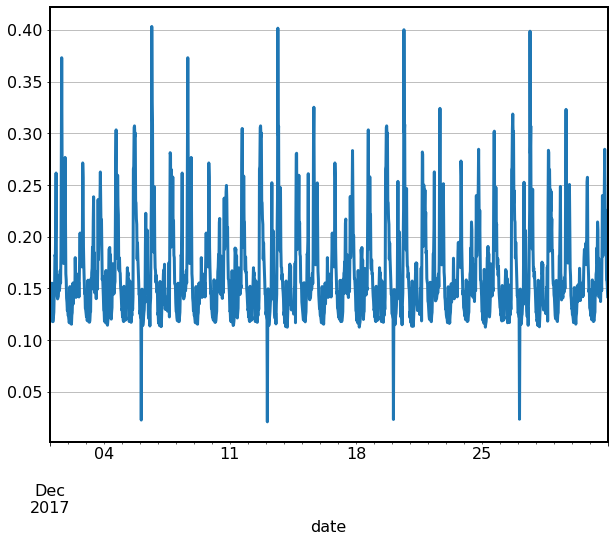

In [74]:
ax1 = figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16)
forecast5.plot(ax=ax1,grid=True,lw=3.0)
plt.show()

In [75]:
# Evaluation metrics
def RMSE(forecast: pd.Series,real: pd.Series):
    return np.sqrt(sum((forecast.values - real.values)**2)/len(forecast.values))

def MSE(forecast: pd.Series,real: pd.Series):
    return sum((forecast.values - real.values)**2)/len(forecast.values)

def NRMSE(forecast: pd.Series,real: pd.Series):
    ymax = real.max()
    ymin = real.min()
    RMSE = np.sqrt(sum((forecast.values - real.values)**2)/len(forecast.values))
    return RMSE/(ymax-ymin)

def MAE(forecast: pd.Series,real: pd.Series):
    return sum(abs(forecast.values - real.values))/len(forecast.values)

def MAPE(forecast: pd.Series,real: pd.Series):
    return sum(abs((forecast.values - real.values)/real.values))/len(forecast.values)

In [ ]:
# get the time-series without zero consumptions
fval = fullYeardata.values
collection = []
for i in np.arange(0,fval.shape[0]):
    for j in np.arange(0,fval.shape[1]):
        if fval[i,j] == 0:
            # print("i: %s, j: %s, value: %s"%(i,j,fval[i,j]))
            collection.append(j)

In [ ]:
collection_set = set(collection)